In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, InputLayer, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.utils import multi_gpu_model
import keras_metrics
import pandas
import ast
import numpy as np
from PIL import Image

Using TensorFlow backend.


In [3]:
import keras.backend as K
import numpy as np
import random

def yolf_loss(y_true, y_pred):
    b_xy_pred = y_pred[..., :2]
    b_wh_pred = y_pred[..., 2:4]
    b_xy = y_true[..., 0:2]
    b_wh = y_true[..., 2:4]
    #print(b_xy_pred.get_shape(),b_xy.get_shape())
    #print(b_wh_pred.get_shape(),b_wh.get_shape())
    #indicator_coord = K.expand_dims(y_true[..., 3], axis=-1) * 1.0
    loss_xy = K.sum(K.square(b_xy - b_xy_pred), axis=-1)# * indicator_coord)#, axis=[1,2,3,4])
    loss_wh = K.sum(K.square(K.sqrt(b_wh) - K.sqrt(b_wh_pred)), axis=-1)# * indicator_coord)#, axis=[1,2,3,4])
    return (loss_wh + loss_xy)/2



In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
train_set = "/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/train/"
validation_set = "/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/val/"
test_set = "/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/test/"

In [6]:
train_df = pandas.read_csv("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/train/output_final.csv")
valid_df = pandas.read_csv("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/val/output_final.csv")
test_df = pandas.read_csv("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/test/output_final.csv")

In [7]:
print("Media x",train_df.x_1.mean(), "stdev" ,train_df.x_1.std() )
print("Media y",train_df.y_1.mean(), "stdev" ,train_df.y_1.std() )
print("Media width",train_df.width.mean(), "stdev" ,train_df.width.std() )
print("Media height",train_df.height.mean(), "stdev" ,train_df.height.std() )

Media x 64.58512537704519 stdev 26.891974565397152
Media y 32.60077998842205 stdev 15.174628915468913
Media width 95.51279363821943 stdev 36.38114831474184
Media height 108.92919167606105 stdev 40.34061374455105


In [8]:
print("Media x",valid_df.x_1.mean(), "stdev" ,valid_df.x_1.std())
print("Media y",valid_df.y_1.mean(), "stdev" ,valid_df.y_1.std())
print("Media width",valid_df.width.mean(), "stdev" ,valid_df.width.std() )
print("Media height",valid_df.height.mean(), "stdev" ,valid_df.height.std() )

Media x 64.62334101129757 stdev 26.993578345104307
Media y 32.69935285729955 stdev 15.22792311959398
Media width 95.49484479543709 stdev 36.539656449787245
Media height 109.07529889217945 stdev 40.39441074706963


In [9]:
train_df.head(2)

,Unnamed: 0,image_id,x_1,y_1,width,height
0,0,021905.jpg,57,37,133,123
1,1,013220.jpg,72,27,78,92


57 37 133 123


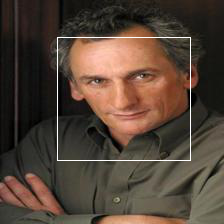

72 27 78 92


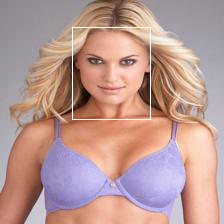

128 71 17 32


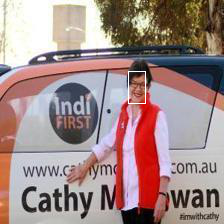

65 43 118 115


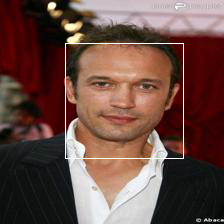

55 18 82 76


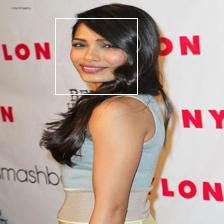

In [10]:
from PIL import Image, ImageDraw
path_train_image = train_set
count = 0 
for index,row in train_df.iterrows(): 
    count = count +1 
    img_path = path_train_image + "/" + row['image_id']
    im = Image.open(img_path)
    x,y,w,h =row['x_1'],row['y_1'],row['width'],row['height']
    print(x,y,w,h)  
    #plt.imshow(img) 
    draw = ImageDraw.Draw(im)
    draw.rectangle(((x, y), (x+w, y+h)))
    display(im)
    # Add the patch to the Axes 
    if count == 5: 
        break

In [11]:
BATCH_SIZE = 256
IMG_SIZE = 224
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.4,1.0])

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_set,
        x_col="image_id",
        y_col=["x_1","y_1","width","height"],
        class_mode="raw",
        #shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=validation_set,
        x_col="image_id",
        y_col=["x_1","y_1","width","height"],
        class_mode="raw",
        #shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 164105 validated image filenames.
Found 18234 validated image filenames.


In [12]:
step_size_train = train_generator.samples/train_generator.batch_size
step_size_valid = valid_generator.samples/valid_generator.batch_size

In [13]:
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
          
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
# get a square for each 7x7 segment

#model.add(Conv2D(filters=4, kernel_size=(1,1), padding="same", activation="relu"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

In [14]:
#model.summary()

#model.add(Flatten())
model.add(Conv2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(2622, (1, 1)))

In [15]:
rule_4_neurons_number = [int(round(x/(i+1),0)) for (x,i) in zip([196]*2,
                                           range(2))]

In [16]:
model.add(Dense(rule_4_neurons_number[0], activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(rule_4_neurons_number[1], activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [18]:
model = multi_gpu_model(model, gpus=2) #parallelize model

In [19]:
model.compile(optimizer=Adam(lr = 1e-4), loss='mse', metrics=['mse'])

In [20]:
model.evaluate_generator(valid_generator, steps=step_size_valid, verbose = 1)


72/71 [==============================] - 48s 672ms/step


[7348.3955078125, 7547.314453125]

In [21]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, mode='min')
mcp_save = ModelCheckpoint('yolf_test.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='min')

history = model.fit_generator(generator=train_generator, epochs=100, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=1, callbacks=[mcp_save, earlyStopping, reduce_lr_loss])

Epoch 1/100
642/641 [==============================] - 454s 707ms/step - loss: 1247.4927 - mse: 1248.5527 - val_loss: 250.1464 - val_mse: 269.9592
Epoch 2/100
642/641 [==============================] - 461s 719ms/step - loss: 638.6707 - mse: 639.0476 - val_loss: 156.9934 - val_mse: 157.4006
Epoch 3/100
642/641 [==============================] - 461s 719ms/step - loss: 496.5528 - mse: 496.7640 - val_loss: 163.6105 - val_mse: 187.8157
Epoch 4/100
642/641 [==============================] - 458s 713ms/step - loss: 435.8957 - mse: 435.8756 - val_loss: 101.7566 - val_mse: 67.1567
Epoch 5/100
642/641 [==============================] - 469s 730ms/step - loss: 397.5773 - mse: 397.7027 - val_loss: 104.9737 - val_mse: 114.4926
Epoch 6/100
642/641 [==============================] - 468s 729ms/step - loss: 370.5969 - mse: 370.5851 - val_loss: 59.0586 - val_mse: 73.4337
Epoch 7/100
642/641 [==============================] - 460s 717ms/step - loss: 354.8533 - mse: 355.0041 - val_loss: 105.0796 - val_

Epoch 58/100
642/641 [==============================] - 457s 711ms/step - loss: 231.4057 - mse: 231.2697 - val_loss: 29.0954 - val_mse: 36.2369
Epoch 59/100
642/641 [==============================] - 456s 711ms/step - loss: 232.1501 - mse: 232.1099 - val_loss: 35.2183 - val_mse: 42.1055
Epoch 60/100
642/641 [==============================] - 459s 715ms/step - loss: 228.1297 - mse: 228.2375 - val_loss: 36.3997 - val_mse: 48.2000
Epoch 61/100
642/641 [==============================] - 453s 706ms/step - loss: 227.3865 - mse: 227.4846 - val_loss: 37.5512 - val_mse: 41.0937
Epoch 62/100
642/641 [==============================] - 452s 704ms/step - loss: 226.6600 - mse: 226.7634 - val_loss: 35.5794 - val_mse: 39.8544

Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 63/100
642/641 [==============================] - 459s 716ms/step - loss: 222.6617 - mse: 222.7799 - val_loss: 33.4953 - val_mse: 33.2903
Epoch 64/100
642/641 [==============================] -

In [22]:
acc = history.history['yolf_loss']
val_acc = history.history['val_yolf_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1000])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Yolo loss')
plt.ylim([0,1000])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: 'yolf_loss'

In [ ]:
import pandas as pd
dict_data = history.history
df = pd.DataFrame.from_dict(dict_data, dtype=float)
csv_file = "yolf_test.csv"
df.to_csv(csv_file)

model_json = model.to_json()
with open("yolf_test.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("resnet50.h5")
print("Saved model to disk")

In [ ]:
import keras

In [ ]:
json_file = open('yolf_test.json', 'r') 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = keras.models.model_from_json(loaded_model_json) 
loaded_model.summary()

In [ ]:
#load weights into new model 
loaded_model.load_weights("yolf_test.h5") 
print("Loaded model from disk") 
#evaluate loaded model on test data 
loaded_model.compile(optimizer= keras.optimizers.Adam(lr=1e-3), loss = 'mse', metrics=['mse'])

In [ ]:
BATCH_SIZE = 256
IMG_SIZE = 224
train_datagen = ImageDataGenerator(
    rescale=1./255)


valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=validation_set,
        x_col="image_id",
        y_col=["x_1","y_1","width","height"],
        class_mode="raw",
        #shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

STEP_SIZE_TEST = valid_generator.n / valid_generator.batch_size 


#CHANGE PARALLEL MODEL
pred=loaded_model.predict_generator(valid_generator,  steps=STEP_SIZE_TEST,  verbose=1)

In [ ]:
print(pred[1],pred[2],pred[3])

In [ ]:
print("Media x",valid_df.x_1.mean(), "stdev" ,valid_df.x_1.std() )
print("Media y",valid_df.y_1.mean(), "stdev" ,valid_df.y_1.std() )
print("Media width",valid_df.width.mean(), "stdev" ,valid_df.width.std() )
print("Media height",valid_df.height.mean(), "stdev" ,valid_df.height.std() )

In [ ]:
print("Media x",pred[:,0].mean(), "stdev" ,pred[:,0].std() )
print("Media y",pred[:,1].mean(), "stdev" ,pred[:,1].std() )
print("Media w",pred[:,2].mean(), "stdev" ,pred[:,2].std() )
print("Media h",pred[:,3].mean(), "stdev" ,pred[:,3].std() )

In [ ]:
from PIL import  Image, ImageDraw

count = 0

for gen_image in test_generator:
    img = Image.fromarray(np.uint8((gen_image[0][0])*255))
    img1 = ImageDraw.Draw(img)
    x1,y1 = pred[count][0],pred[count][1]
    x4,y4= pred[count][0] + pred[count][2], pred[count][1] + pred[count][3]
    img1.rectangle([(x1,y1),(x4,y4)], outline ="red") 
    #img.show() 
    img.save("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/results_yolf_v2/output"+ str(count) + ".jpg")
    #print(gen_image[0][0].shape,pred[count])
    count = count + 1
    if count == 200:
        break